In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# read train and test set
train = pd.read_csv('/content/drive/MyDrive/csv Files/titanic.zip (Unzipped Files)/train.csv')
test = pd.read_csv('/content/drive/MyDrive/csv Files/titanic.zip (Unzipped Files)/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Explorative Data Analysis #

We concentrate first on the 'Pclass' column.

In [ ]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

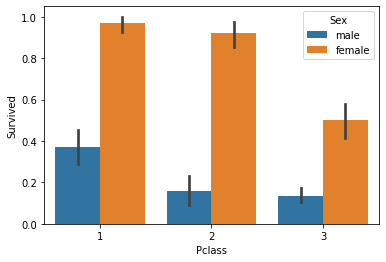

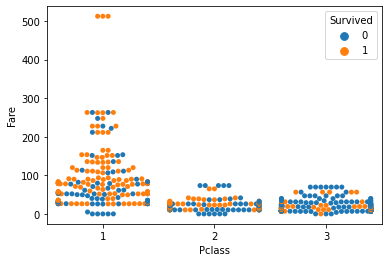

In [ ]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)
plt.show()
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', data=train)

The barplots above underline two interesting facts. The first one is that for each class more women survived than men, probably beacause in case of dangerous situations they must be saved first. The second is that most of the people who survived had payed a higher fare, thus implying that maybe they had some sort of advantage.

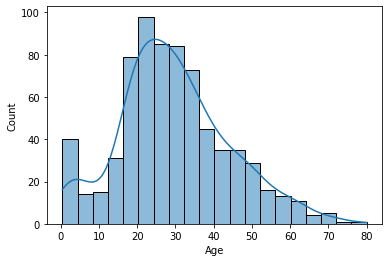

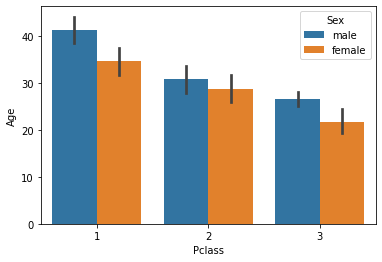

In [ ]:
sns.histplot(data=train.Age, kde=True)
plt.show()
sns.barplot(x='Pclass', y='Age', hue='Sex', data=train)

Most people are 15 to 35 years old and there is almost no pessanger with more than 70 years; on the other side there is a significant number of population within the 0 to 5 years old range. For each class men are always older than women.

# Data cleaning #

Before starting we observe that the 'Name' column is not relevant to our purpose, since survived passengers have to be identified by their Id. We will drop also the 'Ticket' colmn as it should not contain relevant informations.

In [ ]:
# copy the dataset to avoid changing original data
X = train.copy()
X.drop(['Name', 'Ticket'], axis = 1, inplace = True)
X.reset_index(drop = True, inplace = True)

In [ ]:
X.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [ ]:
X.shape[0]

891

In [ ]:
train.shape[0]

891

Next we search for missing values in our data.

In [ ]:
print('Percentage of missing values in:')
for col in X.columns:
    if X[col].isnull().sum() > 0:
        print(col, (X[col].isnull().sum() / X.shape[0])*100)

Percentage of missing values in:
Age 19.865319865319865
Cabin 77.10437710437711
Embarked 0.22446689113355783


As 'Cabin' has over the 75% of missing values we won't retrieve any relevant information from it: we will just drop it. The 'Embarked' column conversely has less than 1% missing values and therefore we will impute them as 'Unknown'.

In [ ]:
X.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [ ]:
#drop Cabin and fill Embarked
X.drop(['Cabin'],axis=1,inplace=True)
X['Embarked'] = X['Embarked'].fillna('Unknown')

In [ ]:
print('Percentage of missing values in:')
for col in X.columns:
    if X[col].isnull().sum() > 0:
        print(col, (X[col].isnull().sum() / X.shape[0])*100)

Percentage of missing values in:
Age 19.865319865319865


In [ ]:
Y=X['Survived']
X.drop(['Survived'],axis=1,inplace=True)

In [ ]:
print(X.shape[0])
print(Y.shape[0])

891
891


In [ ]:
Y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

# TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])
print(Y_train.shape[0])
print(Y_test.shape[0])

712
179
712
179


In [ ]:
print('Percentage of missing values in:')
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        print(col, (X_train[col].isnull().sum() / X_train.shape[0])*100)

Percentage of missing values in:
Age 19.803370786516854


In [ ]:
print('Percentage of missing values in:')
for col in X_test.columns:
    if X_test[col].isnull().sum() > 0:
        print(col, (X_test[col].isnull().sum() / X_test.shape[0])*100)

Percentage of missing values in:
Age 20.11173184357542


In [ ]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].mean())

# FEATURE ENGINEERING

In [ ]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,141,3,female,29.745184,0,2,15.2458,C
439,440,2,male,31.000000,0,0,10.5000,S
817,818,2,male,31.000000,1,1,37.0042,C
378,379,3,male,20.000000,0,0,4.0125,C
491,492,3,male,21.000000,0,0,7.2500,S


In [ ]:
X['Pclass'] = X['Pclass'].astype('object')
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Pclass', 'Sex', 'Embarked']

### Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [ ]:
X_train_le=X_train
X_train_le.Embarked = le.fit_transform(X_train_le.Embarked)

In [ ]:
le2=LabelEncoder()
X_train_le.Sex = le2.fit_transform(X_train_le.Sex)

In [ ]:
le3=LabelEncoder()
X_train_le.Pclass = le3.fit_transform(X_train_le.Pclass)

In [ ]:
X_train_le.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,141,2,0,29.745184,0,2,15.2458,0
439,440,1,1,31.000000,0,0,10.5000,2
817,818,1,1,31.000000,1,1,37.0042,0
378,379,2,1,20.000000,0,0,4.0125,0
491,492,2,1,21.000000,0,0,7.2500,2


In [ ]:
X_test_le=X_test
X_test_le.Embarked = le.transform(X_test_le.Embarked)
X_test_le.Sex = le2.transform(X_test_le.Sex)
X_test_le.Pclass = le3.transform(X_test_le.Pclass)

In [ ]:
X_test_le.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
495,496,2,1,29.745184,0,0,14.4583,0
648,649,2,1,29.745184,0,0,7.5500,2
278,279,2,1,7.000000,4,1,29.1250,1
31,32,0,0,29.745184,1,0,146.5208,0
255,256,2,0,29.000000,0,2,15.2458,0


In [ ]:
cl=['Embarked','Pclass']
X_train_n = pd.get_dummies(X_train_le, columns=cl)
X_train_n.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Pclass_0,Pclass_1,Pclass_2
140,141,0,29.745184,0,2,15.2458,1,0,0,0,0,0,1
439,440,1,31.000000,0,0,10.5000,0,0,1,0,0,1,0
817,818,1,31.000000,1,1,37.0042,1,0,0,0,0,1,0
378,379,1,20.000000,0,0,4.0125,1,0,0,0,0,0,1
491,492,1,21.000000,0,0,7.2500,0,0,1,0,0,0,1


In [ ]:
X_test_n = pd.get_dummies(X_test_le, columns=cl)
X_test_n.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Pclass_0,Pclass_1,Pclass_2
495,496,1,29.745184,0,0,14.4583,1,0,0,0,0,1
648,649,1,29.745184,0,0,7.5500,0,0,1,0,0,1
278,279,1,7.000000,4,1,29.1250,0,1,0,0,0,1
31,32,0,29.745184,1,0,146.5208,1,0,0,1,0,0
255,256,0,29.000000,0,2,15.2458,1,0,0,0,0,1


In [ ]:
X_train_n.reset_index(drop = True, inplace = True)
Y_train.reset_index(drop = True, inplace = True)

In [ ]:
X_test_n.reset_index(drop = True, inplace = True)
Y_test.reset_index(drop = True, inplace = True)

In [ ]:
for i in range(X_test_n.shape[0]):
    X_test_n.loc[i,'Embarked_3']=int(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_nn = ss.fit_transform(X_train_n)
X_test_nn = ss.transform(X_test_n)

# RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_nn,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds=clf.predict(X_test_nn)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.69      0.75      0.72        69

    accuracy                           0.78       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



## For test data

In [ ]:
test_copy=test.copy()

In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
test.drop(['Name', 'Ticket'], axis = 1, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
test.drop(['Cabin'], axis = 1, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
print('Percentage of missing values in:')
for col in test.columns:
    if test[col].isnull().sum() > 0:
        print(col, (test[col].isnull().sum() / test.shape[0])*100)

Percentage of missing values in:
Age 20.574162679425836
Fare 0.23923444976076555


In [ ]:
test['Age'] = test['Age'].fillna(X_train['Age'].mean())
test['Fare'] = test['Fare'].fillna(X_train['Fare'].mean())

In [ ]:
test_le=test
test_le.Embarked = le.transform(test_le.Embarked)
test_le.Sex = le2.transform(test_le.Sex)
test_le.Pclass = le3.transform(test_le.Pclass)

In [ ]:
test_n = pd.get_dummies(test_le, columns=cl)
test_n.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Pclass_0,Pclass_1,Pclass_2
0,892,1,34.5,0,0,7.8292,0,1,0,0,0,1
1,893,0,47.0,1,0,7.0000,0,0,1,0,0,1
2,894,1,62.0,0,0,9.6875,0,1,0,0,1,0
3,895,1,27.0,0,0,8.6625,0,0,1,0,0,1
4,896,0,22.0,1,1,12.2875,0,0,1,0,0,1


In [ ]:
for i in range(test_n.shape[0]):
    test_n.loc[i,'Embarked_3']=int(0)

In [ ]:
test_nn = ss.transform(test_n)

In [ ]:
final_test_preds=clf.predict(test_nn)

In [ ]:
for i in range(test_copy.shape[0]):
    test_copy.loc[i,'Predicted_Survived']=str(final_test_preds[i])

In [ ]:
test_copy.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
test_copy.to_csv('RF_output.csv')
!cp RF_output.csv '/content/drive/MyDrive/Cureya/Out_csv/Week4/'

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg')
lr.fit(X_train_nn,Y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds=lr.predict(X_test_nn)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.66      0.77       110
           1       0.63      0.90      0.74        69

    accuracy                           0.75       179
   macro avg       0.77      0.78      0.75       179
weighted avg       0.80      0.75      0.76       179



##For test dataset

In [ ]:
final_test_preds = lr.predict(test_nn)

In [ ]:
test_copy.drop(columns = ['Predicted_Survived'])
for i in range(test_copy.shape[0]):
    test_copy.loc[i,'Predicted_Survived']=str(final_test_preds[i])
test_copy.head()    

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
test_copy.to_csv('LR_output.csv')
!cp LR_output.csv '/content/drive/MyDrive/Cureya/Out_csv/Week4/'

#SVM

In [ ]:
from sklearn import svm
sv = svm.SVC()
sv.fit(X_train_nn,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
preds=sv.predict(X_test_nn)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80       110
           1       0.66      0.91      0.76        69

    accuracy                           0.78       179
   macro avg       0.79      0.81      0.78       179
weighted avg       0.82      0.78      0.78       179



##For test dataset

In [ ]:
final_test_preds = sv.predict(test_nn)

In [ ]:
test_copy.drop(columns = ['Predicted_Survived'])
for i in range(test_copy.shape[0]):
    test_copy.loc[i,'Predicted_Survived']=str(final_test_preds[i])
test_copy.head()    

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
test_copy.to_csv('SVM_output.csv')
!cp SVM_output.csv '/content/drive/MyDrive/Cureya/Out_csv/Week4/'

#XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train_nn,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
preds=xg.predict(X_test_nn)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 

In [ ]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       110
           1       0.74      0.75      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



##For test data

In [ ]:
final_test_preds = xg.predict(test_nn)

In [ ]:
test_copy.drop(columns = ['Predicted_Survived'])
for i in range(test_copy.shape[0]):
    test_copy.loc[i,'Predicted_Survived']=str(final_test_preds[i])
test_copy.head() 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
test_copy.to_csv('XG_output.csv')
!cp XG_output.csv '/content/drive/MyDrive/Cureya/Out_csv/Week4/'

##GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
#xg.get_params()
parameters = {'learning_rate': [0.01,0.02,0.03],
              'subsample'    : [0.9, 0.5, 0.2],
              'n_estimators' : [100,500,1000],
              'max_depth'    : [4,6,8]
                 }
grid_xg = GridSearchCV(estimator=xg, param_grid = parameters, cv = 2, n_jobs=-1)

In [ ]:
grid_xg.fit(X_train_nn,Y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000],
         

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xg.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xg.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xg.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

 The best score across ALL searched params:
 0.800561797752809

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}


In [ ]:
preds = grid_xg.predict(X_test_nn)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       110
           1       0.74      0.75      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



##For test data

In [ ]:
final_test_preds = grid_xg.predict(test_nn)

In [ ]:
test_copy.drop(columns = ['Predicted_Survived'])
for i in range(test_copy.shape[0]):
    test_copy.loc[i,'Predicted_Survived']=str(final_test_preds[i])
test_copy.head() 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted_Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [ ]:
test_copy.to_csv('gridXG_output.csv')
!cp gridXG_output.csv '/content/drive/MyDrive/Cureya/Out_csv/Week4/'

###*From the above findings we can conclude that XGBoost with GridSearchCV is the best model to predict wether a passenger survived or not.*